<a href="https://colab.research.google.com/github/kmuenpra/EECE7268/blob/main/EECE7268_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECE/CS 7268: Verifiable Machine Learning -- Fall 2025
# HW#2: Formal Verification

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

The goal of this assignment is to give you hands-on experience with formal verification of neural networks. You will code some verification algorithms from scratch in the first few problems to build an understanding of how these concepts from class actually play out in code. Then, you will get to use some libraries to gain familiarity with state-of-the-art software in this research field.

You're welcome to use PyTorch, TensorFlow, Keras, or other appropriate libraries to help make your life easier throughout the problems - we tried to make the function signatures somewhat framework-agnostic.

 **Please provide your collaboration statement here or we will assign a zero on this assignment**:


For this assignment, we'll use the [NNet](https://github.com/sisl/nnet) format as a language/framework-agnostic description of a ReLU network and its parameters. Here are some possibly useful functions that convert between nnet, numpy arrays, and pytorch models (feel free to use these or not).

In [1]:
import torch
import numpy as np
import cvxpy as cp
from enum import Enum
import matplotlib.pyplot as plt

In [2]:
def nnet_to_weights_and_biases(nnet_filename: str) -> tuple[np.ndarray, np.ndarray]:
  # load a nnet text file and extract the weights and biases

  # converted this code from: https://github.com/sisl/NeuralVerification.jl/blob/957cb32081f37de57d84d7f0813f708288b56271/src/utils/util.jl#L10
  with open(nnet_filename, 'r') as f:
    line = f.readline()
    while "//" in line: #skip comments
      line = f.readline()
    # number of layers
    nlayers = int(line.strip().split(",")[0])
    # read in layer sizes
    layer_sizes = [int(x) for x in f.readline().split(",")[1:nlayers+1]]
    # read past additonal information
    for i in range(1, 6):
      line = f.readline()
    # i=1 corresponds to the input dimension, so it's ignored
    Ws = []
    bs = []
    for dim in layer_sizes:
      W = np.vstack([[float(x) for x in f.readline().rstrip(',\n ').split(",")] for i in range(dim)])
      b = np.array([float(f.readline().rstrip(',\n ')) for _ in range(dim)])
      Ws.append(W)
      bs.append(b)

  return Ws, bs

def weights_and_biases_to_pytorch(Ws: list[np.ndarray], bs: list[np.ndarray]) -> torch.nn.Sequential:
  # given weights and biases, create a torch.nn.Sequential model with relus
  # btwn each linear layer (except no activation on final layer)

  num_layers = len(Ws)

  layers = []
  for W, b in zip(Ws, bs):
    out_features, in_features = W.shape
    layer = torch.nn.Linear(in_features, out_features)
    layer.weight = torch.nn.Parameter(torch.Tensor(W))
    layer.bias = torch.nn.Parameter(torch.Tensor(b))
    layers.append(layer)
    layers.append(torch.nn.ReLU())

  # don't add ReLU to end of NN
  model = torch.nn.Sequential(*layers[:-1])
  return model

def nnet_to_pytorch(nnet_filename: str) -> torch.nn.Sequential:
  # directly convert from nnet text file to pytorch model
  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  model = weights_and_biases_to_pytorch(Ws, bs)
  return model

def model_to_weights_and_biases(model: torch.nn.Sequential) -> tuple[np.ndarray, np.ndarray]:
  # extract the weights and biases as numpy arrays from a torch.nn.Sequential model
  Ws = []
  bs = []
  for idx, m in enumerate(model.modules()):
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      continue
    elif isinstance(m, torch.nn.Linear):
      Ws.append(m.weight.data.numpy())
      bs.append(m.bias.data.numpy())
    else:
      print("That layer isn't supported.")
      assert 0
  return Ws, bs

In [3]:
def nominal_and_epsilon_to_range(nominal: np.ndarray, epsilon: np.ndarray | float) -> np.ndarray:
  return np.vstack([nominal-epsilon, nominal+epsilon]).T

def range_to_nominal_and_epsilon(input_range: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
  nominal_input = (input_range[:, 1] + input_range[:, 0]) / 2.
  epsilon = (input_range[:, 1] - input_range[:, 0]) / 2.
  return nominal_input, epsilon

For example, to load a NN controller for a cartpole system, then query the controller for its action at a particular state:

In [4]:
print("Cartpole Controller")

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename = "/cartpole_nnet-1.nnet"
nominal_input = torch.Tensor([[0., 0.1, 0.2, 0.3]]) # these 4 values correspond to the 4 states in cartpole
model = nnet_to_pytorch(nnet_filename)
Ws, bs = model_to_weights_and_biases(model)
nominal_output = model(nominal_input)
print(f"{nominal_output=}")

# Also set up an example set of possible inputs to this NN
epsilon = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
input_range = nominal_and_epsilon_to_range(nominal_input, epsilon)
print(f"{input_range=}")

Cartpole Controller
nominal_output=tensor([[12.9007, -1.4208]], grad_fn=<AddmmBackward0>)
input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)


# Problem 1: Sampling-Based Under-Approximations

One way to approximate the set of possible NN outputs for a given set of possible NN inputs is by exhaustively sampling. Here, you will implement a simple sampling-based method for estimating the min and max values for each dimension of the NN output. This sampling-based strategy provides an under-approximation of the output set (and the corresponding rectangular bound is an under-approximation of the axis-aligned bounding box around the true output set).

The cartpole NN only has 4 inputs and 2 outputs, so you can visualize its output samples easily.

**Deliverables**:

- Implement the `output_range_sampling` function
- For the cartpole NN, plot your output samples and the corresponding rectangular bounds for a few different values of `num_samples`


In [22]:
def output_range_sampling(nnet_filename: str, input_range: np.ndarray, num_samples: int) -> np.ndarray:

  # Load the NNet file and pass a nominal input to get the class logits
  model = nnet_to_pytorch(nnet_filename)
  model.eval()

  random_sample_X = np.random.uniform(low=input_range[:,0], high=input_range[:,1], size=(num_samples, len(input_range[:,0]))).astype(np.float32)
  X_torch = torch.from_numpy(random_sample_X)

  with torch.no_grad():
      Y = model(X_torch).numpy()   # shape: (num_samples, m)
      print(Y[:4])

  # Compute elementwise min and max across samples
  y0_min = np.min(Y[:,0], axis=0)
  y0_max = np.max(Y[:,0], axis=0)

  y1_min = np.min(Y[:,1], axis=0)
  y1_max = np.max(Y[:,1], axis=0)

  return Y, [[y0_min, y0_max], [y1_min, y1_max]]

num_samples = int(1e4)
output_samples, output_range = output_range_sampling(nnet_filename, input_range, num_samples)
print(output_range)

[[13.667432  -1.7003391]
 [13.36579   -1.7081702]
 [11.95388   -1.283196 ]
 [13.887407  -1.8715401]]
[[np.float32(11.399587), np.float32(16.09776)], [np.float32(-4.112251), np.float32(-1.0959299)]]


Text(0, 0.5, 'Output Dim 1')

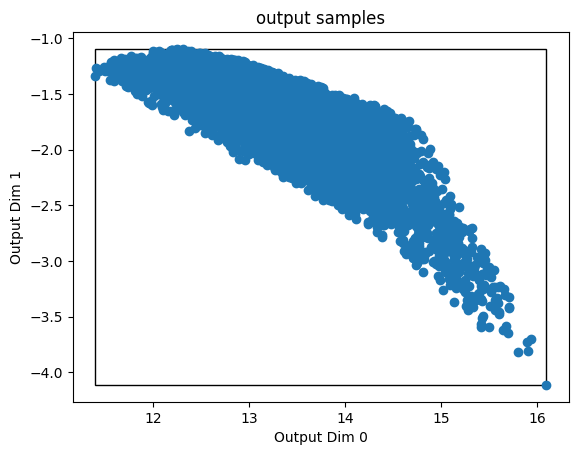

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

output0_range  = output_range[0]
output1_range  = output_range[1]

fig, ax = plt.subplots()

width  = output0_range[1] - output0_range[0]
height = output1_range[1] - output1_range[0]
r = Rectangle((output0_range[0], output1_range[0]), width, height, fill=False)
ax.add_patch(r)
ax.scatter(output_samples[:,0], output_samples[:,1])
ax.set_title("output samples")
ax.set_xlabel("Output Dim 0")
ax.set_ylabel("Output Dim 1")

# Problem 2: Interval Bound Propagation (IBP)

Now, you will implement the IBP algorithm to get *outer* bounds on the output set -- which are much more useful for proving that the NN will not produce undesired outputs. You may want to read [the IBP paper](https://arxiv.org/pdf/1810.12715.pdf) (especially around Eqn 6) to help with this.

**Deliverables:**

- Implement the `verify_ibp` function
- Print the `output_range` from your IBP implementation
- Plot your IBP rectangular bounds along with the samples from above to see how ridiculously loose IBP bounds can be

### NOTE to Self

Weight and bias:

W1: (16, 4),   b1: (16,)

W2: (16, 16),  b2: (16,)

W3: (16, 16),  b3: (16,)

W4: (2, 16),   b4: (2,)

Network:

Input (4) →

Linear(4 → 16) → ReLU →

Linear(16 → 16) → ReLU →

Linear(16 → 16) → ReLU →

Linear(16 → 2) → Output


In [93]:
def verify_ibp(nnet_filename: str, input_range: np.ndarray) -> np.ndarray:

  # Load the NNet file and pass a nominal input to get the class logits
  model = nnet_to_pytorch(nnet_filename)
  model.eval()

  Ws, bs = model_to_weights_and_biases(model)


  #----------- IBP (Gowal, 2016) - Eq. 6 -----------
  z_k_lb = input_range[:,0]
  z_k_ub = input_range[:,1]

  layer_count = 1 #Might be a better way
  for W, b in zip(Ws, bs):
    W = np.array(W)
    b = np.array(b)

    mu = (z_k_ub + z_k_lb)/2
    r = (z_k_ub - z_k_lb)/2

    # print(W.shape)
    # print(mu.shape)
    # print(r.shape)
    # print(b.shape)
    mu_k = W @ mu + b
    r_k = np.absolute(W) @ r

    z_k_lb = mu_k - r_k
    z_k_ub = mu_k + r_k

    if layer_count < len(Ws):
      #apply Relu
      z_k_lb = np.maximum(0, z_k_lb)
      z_k_ub = np.maximum(0, z_k_ub)

    layer_count += 1

    #----------------------------------------------

    # print(z_k_lb)
    # print(z_k_ub)

  return [np.array([z_k_lb[0],z_k_ub[0]]), np.array([z_k_lb[1],z_k_ub[1]])]

output_range_ibp = verify_ibp(nnet_filename, input_range)
print(f"{output_range_ibp=}")

output_range_ibp=[array([-25.6073 ,  52.51912], dtype=float32), array([-32.457947,  23.750446], dtype=float32)]


# Problem 3: Linear Program (LP)

Since IBP's bounds are usually too loose to say something useful about the NN's output set, you will now implement an LP-based verification algorithm that should provide much tighter bounds while remaining computationally reasonable.

You will set up an LP (e.g., using `cvxpy` to set up variables, constraints, and objectives corresponding to the NN verification problem) for each side of the rectangle (i.e., min & max per output dimension, which can be done by simply changing the objective). To turn the ReLU constraints into linear equality/inequality constraints, you can check which neurons are "active", "inactive", or "uncertain" and add the corresponding relaxed constraints. To know which neurons belong to which category, you will need to acquire intermediate bounds -- there are lots of ways to do this!

In [95]:
def verify_lp(nnet_filename: str, input_range: np.ndarray) -> np.ndarray:

  # TODO: implement this!

  # Load the NNet file and pass a nominal input to get the class logits
  model = nnet_to_pytorch(nnet_filename)
  model.eval()

  Ws, bs = model_to_weights_and_biases(model)

  #input bounds
  l_in = input_range[:,0]
  u_in = input_range[:,1]

  # Variables
  x = cp.Variable(4)  # input
  constraints = [x >= l_in, x <= u_in]  # input box constraints

  y_prev = x
  relu_outputs = []   # keep y vars for hidden layers
  a_vars = []         # binary vars for each layer
  bounds = []         # store (l,u) per layer

  for layer_idx in range(len(Ws)-1):   # 3 hidden layers with ReLU
      W, b = Ws[layer_idx], bs[layer_idx]

      # Compute pre-activation bounds
      l_z = W.clip(min=0) @ l_in + W.clip(max=0) @ u_in + b
      u_z = W.clip(min=0) @ u_in + W.clip(max=0) @ l_in + b
      bounds.append((l_z, u_z))

      # Variables
      z = W @ y_prev + b
      y = cp.Variable(W.shape[0])
      a = cp.Variable(W.shape[0], boolean=True) #binary var

      # Add ReLU MILP constraints y = Relu(z)
      for j in range(W.shape[0]):
          l_j, u_j = l_z[j], u_z[j]
          constraints += [
              y[j] <= z[j] - l_j*(1 - a[j]),
              y[j] >= z[j],
              y[j] <= u_j*a[j],
              y[j] >= 0
          ]

      relu_outputs.append(y)
      a_vars.append(a)

      # Update bounds for next layer
      l_in, u_in = np.maximum(0, l_z), np.maximum(0, u_z)
      y_prev = y

  # last layer without Relu
  f_out = Ws[-1] @ y_prev + bs[-1]


  #FINd tightest bound for output
  output_range = []

  #output Dim 1
  c = np.array([1, 0])  # margin vector
  objective = cp.Minimize(c @ f_out)
  prob = cp.Problem(objective, constraints)
  prob.solve(verbose=False)
  output_range.append(f_out.value[0])

  c = np.array([1, 0])  # margin vector
  objective = cp.Maximize(c @ f_out)
  prob = cp.Problem(objective, constraints)
  prob.solve(verbose=False)
  output_range.append(f_out.value[0])

  #output Dim 2
  c = np.array([0, 1])  # margin vector
  objective = cp.Minimize(c @ f_out)
  prob = cp.Problem(objective, constraints)
  prob.solve(verbose=False)
  output_range.append(f_out.value[1])

  c = np.array([0, 1])  # margin vector
  objective = cp.Maximize(c @ f_out)
  prob = cp.Problem(objective, constraints)
  prob.solve(verbose=False)
  output_range.append(f_out.value[1])


  return output_range

output_range_lp = verify_lp(nnet_filename, input_range)
print(f"{output_range_lp=}")

output_range_lp=[np.float64(11.166060961949457), np.float64(16.436482699165452), np.float64(-4.379835748243782), np.float64(-1.0875090467602182)]


# Problem 4: Verify Classifier Robustness

So far, you have written verification algorithms that provide upper and lower bounds on each output of the NN. Here, you will slightly modify your LP verifier so that it verifies the *robustness* of a *classifier* (i.e., prove that the classifier predicts the same class for every input within some range).

If the verification algorithm is able to prove robustness, you should return `VerifierResults.Robust`. If the verification algorithm is unable to prove robustness, you should return `VerifierResults.Unsure` (remember that this doesn't necessarily mean the classifier isn't robust, just that our algorithm failed to find a proof). I also added a `VerifierResults.Timeout` option, because you will often see this in real verification algorithms, but you do not need to use this here.

To start, you can pretend the cartpole controller was a classifier and try to see how large of an epsilon you can specify until you can't verify the robustness anymore.

Then, you can load an MNIST classifier (code below) and try to see how large of an epsilon for which you can still verify robustness around a nominal image. Since the MNIST classifier is a way bigger NN, there will be some impact on the runtime of your LP.

**Deliverables:**

- Implement `verify_classification_robustness_lp`
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the cartpole controller
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the MNIST classifier

In [ ]:
class VerifierResults(Enum):
  Robust = 0
  Unsure = 1
  Timeout = 2

def verify_classification_robustness_lp(nnet_filename: str, input_range: np.ndarray) -> int:

  # TODO: implement this!

  return VerifierResults.Robust

verifier_result = verify_classification_robustness_lp(nnet_filename, input_range)

Load a NN classifier for MNIST, then query the model at a particular image:

In [ ]:
print("MNIST Classifier")

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename_mnist = "mnist1.nnet"

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_index = 2 # this one should be correctly classified as a 4...
nominal_input_mnist = torch.Tensor(x_train[img_index].flatten())
model_mnist = nnet_to_pytorch(nnet_filename_mnist)
Ws_mnist, bs_mnist = model_to_weights_and_biases(model_mnist)
nominal_output = model_mnist(nominal_input_mnist)
nominal_class = nominal_output.argmax()
print(f"{nominal_output=}")
print(f"Predicted Class: {nominal_class}, True Class: {y_train[img_index]}")

# Also set up an example set of possible inputs to this NN

epsilon_mnist = 2*np.ones((784))
input_range_mnist = nominal_and_epsilon_to_range(nominal_input_mnist, epsilon_mnist)
print(f"{input_range_mnist=}")

In [ ]:
verifier_result = verify_classification_robustness_lp(nnet_filename_mnist, input_range_mnist)

# Problem 5: Explore the `jax_verify` library for verification

There are a few excellent open-source libraries for NN verification. For example, `jax_verify` has implementations of IBP, CROWN, and many other algorithms. These methods can handle a broader class of NNs than just the ReLU NNs you worked with above, so they may be useful tools to leverage in your research or projects.

A big upside of `jax_verify` is that it supports JIT compilation, which can speed up verification algorithms by 10-100x (you don't need to set up JIT compilation for this assignment, but you're encouraged to try that out if you're curious).

Note that the `jax_verify` that is available by default in PyPi is an old version from 2020 that has a slightly different API - installing a more recent version is recommended as we do below.

In [ ]:
# Install my fork of jax_verify, which fixes a few deprecation errors in the mainline repo
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify@mainline_repo

In [ ]:
import jax.numpy as jnp
import jax_verify
import functools

Some utility methods that help set up the NN in jax:

In [ ]:
def pytorch_model_to_jax(torch_model: torch.nn.Sequential):
  params = []
  act = None

  # Extract params (weights, biases) from torch layers, to be used in
  # jax.
  # Note: This propagator assumes a feed-forward relu NN.
  for m in torch_model.modules():
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      if act is None or act == "relu":
        act = "relu"
    elif isinstance(m, torch.nn.Linear):
      w = m.weight.data.numpy().T
      b = m.bias.data.numpy()
      params.append((w, b))
  return functools.partial(relu_nn, params)

def relu_nn(params, inputs):
  for W, b in params[:-1]:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  W, b = params[-1]
  return jnp.dot(inputs, W) + b

def jax_interval_to_np_range(interval: jax_verify.IntervalBound) -> np.ndarray:
  return np.vstack([interval.lower, interval.upper]).T

def np_range_to_jax_interval(input_range: np.ndarray) -> jax_verify.IntervalBound:
  return jax_verify.IntervalBound(input_range[:, 0], input_range[:, 1])

jax_model = pytorch_model_to_jax(model)

An example of using jax_verify's implementation of IBP on our cartpole control NN

In [ ]:
# Example of a fwd pass on the NN using jax
nominal_output_jax = jax_model(jnp.array(nominal_input))

# Example of computing bounds using IBP as implemented by jax_verify
input_bounds = np_range_to_jax_interval(input_range)
output_bounds_ibp_jax = jax_verify.interval_bound_propagation(
    jax_model, input_bounds)
output_range_ibp_jax = jax_interval_to_np_range(output_bounds_ibp_jax)
print(f"output bounds via IBP (jax_verify): \n{output_range_ibp_jax}")

Does that output match the output of your IBP implementation?

Now for your job: take a look at jax_verify's documentation to see how to use the backward CROWN verifier.

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

# Problem 6: Explore the `auto-LiRPA` library for verification

`auto-LiRPA` is a verification library based on PyTorch and one of the main developers was a Northeastern PhD student (Kaidi Xu)!

Just like with the previous problem, the next cells show you how to install the package and run IBP, then we ask you to look into their documentation and run backward CROWN on the same problem.

**Note:** I suggest doing this part last, because pip may try to downgrade the version of pytorch installed to satisfy requirements. You may also need to restart your kernel after the pip install. If you're on Colab and things seem messed up, you can always do `Runtime > Disconnect and delete runtime` (stronger than restarting the runtime, which doesn't reset to the default set of installed packages).

In [ ]:
!pip install auto-lirpa

An example of using jax_verify's implementation of IBP on our cartpole control NN:

In [ ]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

# Wrap the model with auto_LiRPA.
model = BoundedModule(model, torch.Tensor(nominal_input))
# Define perturbation. Here we add Linf perturbation to input data.
ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# Make the input a BoundedTensor with the pre-defined perturbation.
my_input = BoundedTensor(torch.Tensor(nominal_input), ptb)
# Regular forward propagation using BoundedTensor works as usual.
prediction = model(my_input)
# Compute LiRPA bounds using IBP
lb, ub = model.compute_bounds(x=(my_input,), method="ibp")
output_range_ibp_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f"output bounds via IBP (auto-lirpa): \n{output_range_ibp_autolirpa}")

Does that match your implementation of IBP? What about `jax_verify`'s?

Now for your job: compute output bounds using `auto-LiRPA`'s implementation of backward CROWN

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

All done!